In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import sys

In [2]:
Nevents = 10000
Nchannel = 1
Xpixels = 232
Ypixels = 124
val_size = 0.25
test_size = 0.05
seed = 8
batch_size = 4

In [3]:
train_low_org = np.zeros((Nevents*11, Ypixels, Xpixels))
train_high_org = np.zeros((Nevents*11, Ypixels, Xpixels))
print("Used memory:", (sys.getsizeof(train_low_org)+sys.getsizeof(train_high_org))/1024./1024./1024., "GB")
for energy in np.arange(0,11):
    prefix = "/data01/JUNO_ML/KE_"+str(energy)+".0MeV/csvfile"
    datalist = pd.read_csv(prefix+"/list.csv", header=None)
    print("Processing events with energy at", energy, "MeV")
    for event in np.arange(0,Nevents):
        if event%1000 == 0:
            print("Processing event:", event)
        train_low_evt = pd.read_csv(prefix+"/low_res/"+datalist.iat[event,0], delimiter="\t", header=None, names=["ID","x","y","time"])
        train_high_evt = pd.read_csv(prefix+"/high_res/"+datalist.iat[event,0], delimiter="\t", header=None, names=["ID","x","y","time"])
        for pmtid in np.arange(0,train_low_evt.shape[0]):
            eventindex = Nevents*energy+event
            train_low_org[eventindex, train_low_evt.at[pmtid,"y"], train_low_evt.at[pmtid,"x"]] = train_low_evt.at[pmtid,"time"]
            train_high_org[eventindex, train_high_evt.at[pmtid,"y"], train_high_evt.at[pmtid,"x"]] = train_high_evt.at[pmtid,"time"]

Used memory: 47.15442681312561 GB
Processing events with energy at 0 MeV
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing events with energy at 1 MeV
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing events with energy at 2 MeV
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing events with energy at 3 MeV
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event:

In [4]:
train_low_org, train_high_org = shuffle(train_low_org, train_high_org, random_state = seed)
train_low, val_low, train_high, val_high = train_test_split(train_low_org, train_high_org, test_size=val_size, random_state=seed)
#train_low, test_low, train_high, test_high = train_test_split(train_low, train_high, test_size=test_size, random_state=seed)
print("train low:", train_low.shape)
print("train high:", train_high.shape)
print("val low:", val_low.shape)
print("val high:", val_high.shape)
#print("test low:", test_low.shape)
#print("test high:", test_high.shape)
train_samples = train_low.shape[0]
val_samples = val_low.shape[0]

train low: (82500, 124, 232)
train high: (82500, 124, 232)
val low: (27500, 124, 232)
val high: (27500, 124, 232)


In [5]:
del train_low_org
del train_high_org

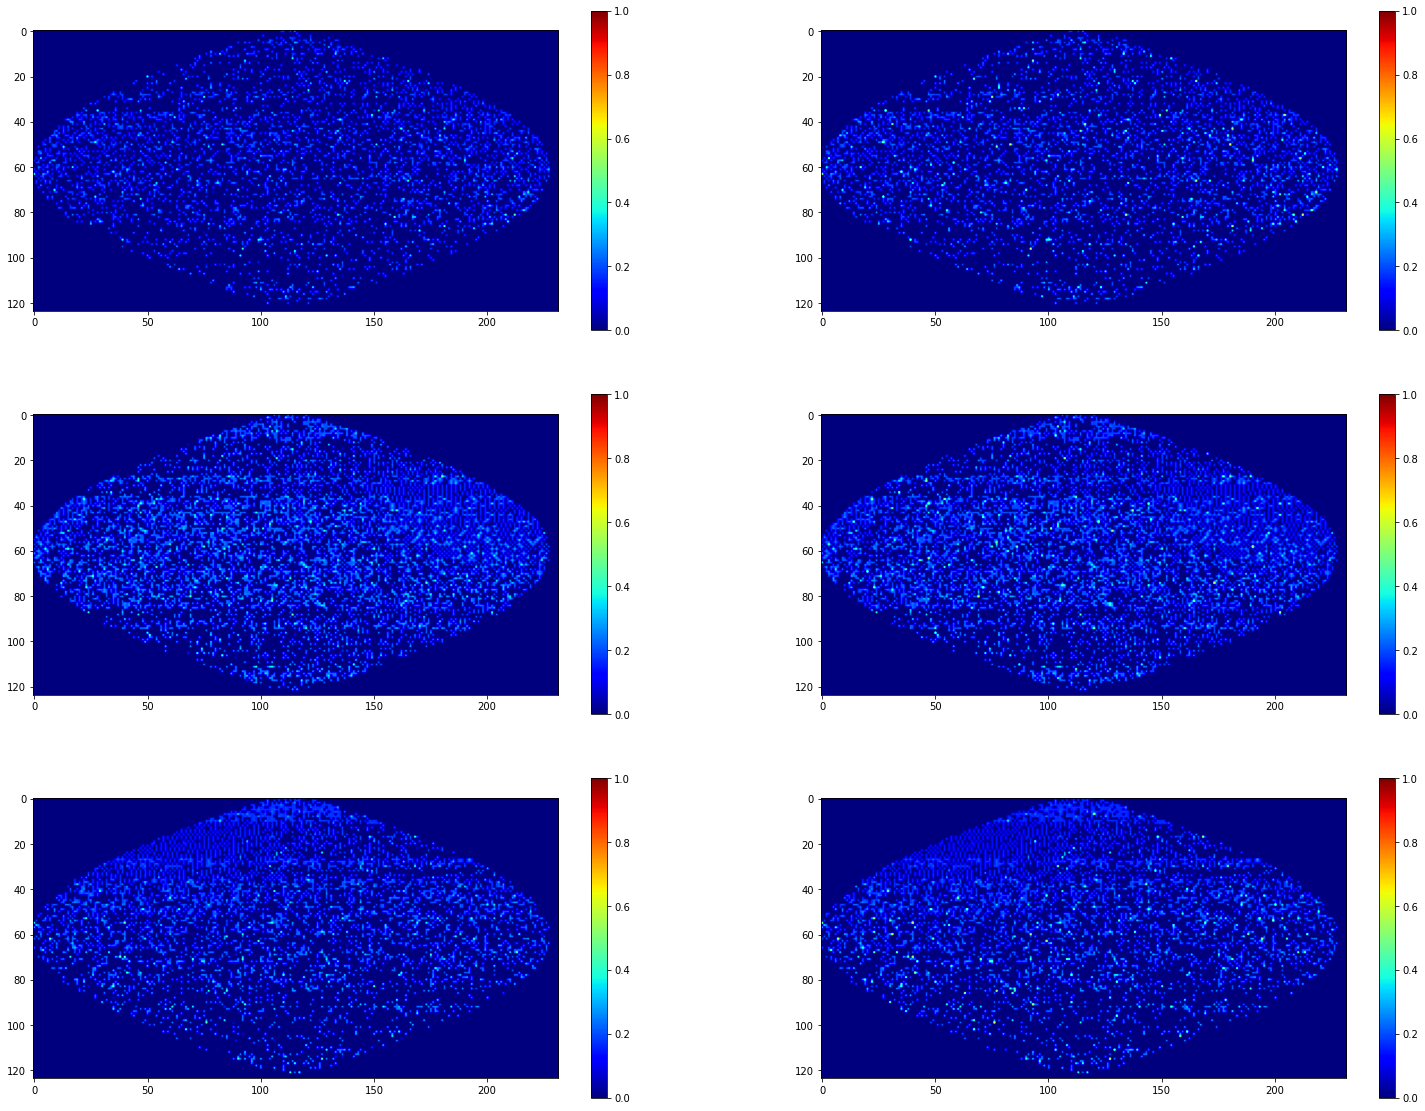

In [6]:
fig = plt.figure(1,figsize=(40,20))
      
for i in np.arange(3):
    ax = fig.add_subplot(3,3,i*3+1)
    plt.imshow(train_low[i,:,:],origin='upper',vmin=0.,vmax=1.0,cmap="jet")
    plt.colorbar()
    ax = fig.add_subplot(3,3,i*3+2)
    plt.imshow(train_high[i,:,:],origin='upper',vmin=0.,vmax=1.0,cmap="jet")
    plt.colorbar()

In [7]:
input_img = Input(shape=(Ypixels, Xpixels, Nchannel))


l1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu')(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu')(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu')(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu')(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu')(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu')(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu')(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu')(l13)

l15 = add([l14, l2])

decoded = Conv2D(Nchannel, (3, 3), padding='same', activation='relu')(l15)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

2023-11-22 21:26:17.642692: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-22 21:26:17.642717: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: userroot-System-Product-Name
2023-11-22 21:26:17.642722: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: userroot-System-Product-Name
2023-11-22 21:26:17.642958: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.223.2
2023-11-22 21:26:17.642976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.199.2
2023-11-22 21:26:17.642980: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.199.2 does not match DSO version 470.223.2 -- cannot find working devices in this configuration
2023-11-22 21:26:17.643266: I tensorflow/core/platfo

In [8]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 124, 232, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 232, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 232, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 116, 64)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
model_path = "autoencoder.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [10]:
hist = autoencoder.fit(x=train_low, y=train_high,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=(val_low, val_high),
                    validation_steps=val_samples//batch_size,
                    epochs=10, callbacks=[earlystop, checkpoint, learning_rate_reduction])
'''
hist = autoencoder.fit(train_img_gen,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=val_image_gen,
                    validation_steps=val_samples//batch_size,
                    epochs=10, callbacks=[earlystop, checkpoint, learning_rate_reduction])
'''

2023-11-22 21:26:19.210608: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9493440000 exceeds 10% of free system memory.
2023-11-22 21:26:24.519155: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9493440000 exceeds 10% of free system memory.
2023-11-22 21:26:26.951229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
20625/20625 [==============================] - 16101s 781ms/step - loss: 2.8426e-04 - accuracy: 0.8203 - val_loss: 2.7217e-04 - val_accuracy: 0.8201

Epoch 00001: val_loss improved from inf to 0.00027, saving model to autoencoder.h5
Epoch 2/10


/home/userroot/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


20625/20625 [==============================] - 16208s 786ms/step - loss: 2.7171e-04 - accuracy: 0.8203 - val_loss: 2.6927e-04 - val_accuracy: 0.8201

Epoch 00002: val_loss improved from 0.00027 to 0.00027, saving model to autoencoder.h5
Epoch 3/10
20625/20625 [==============================] - 16208s 786ms/step - loss: 2.6882e-04 - accuracy: 0.8203 - val_loss: 2.6792e-04 - val_accuracy: 0.8201

Epoch 00003: val_loss improved from 0.00027 to 0.00027, saving model to autoencoder.h5
Epoch 4/10
20625/20625 [==============================] - 16169s 784ms/step - loss: 2.6780e-04 - accuracy: 0.8203 - val_loss: 2.6565e-04 - val_accuracy: 0.8201

Epoch 00004: val_loss improved from 0.00027 to 0.00027, saving model to autoencoder.h5
Epoch 5/10
20625/20625 [==============================] - 16177s 784ms/step - loss: 2.6673e-04 - accuracy: 0.8203 - val_loss: 2.6472e-04 - val_accuracy: 0.8201

Epoch 00005: val_loss improved from 0.00027 to 0.00026, saving model to autoencoder.h5
Epoch 6/10
20625/20

'\nhist = autoencoder.fit(train_img_gen,\n                    steps_per_epoch=train_samples//batch_size,\n                    validation_data=val_image_gen,\n                    validation_steps=val_samples//batch_size,\n                    epochs=10, callbacks=[earlystop, checkpoint, learning_rate_reduction])\n'

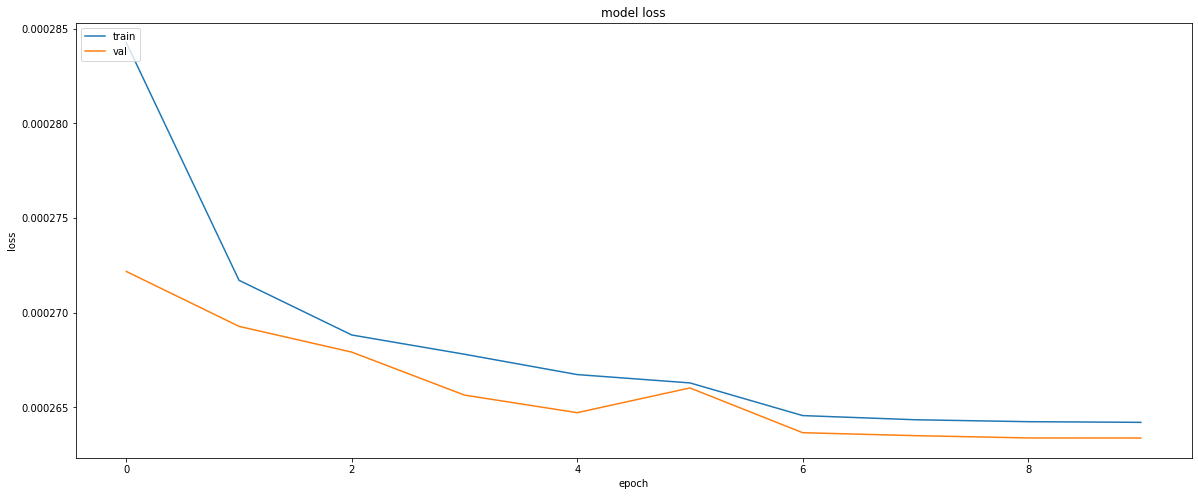

In [11]:
plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
'''
n = 0
for i,m in val_generator:
    img,mask = i,m
    sr1 = autoencoder.predict(img)
    if n < 2:
        #outimg1 = Image.fromarray(img[0],"RGB")
        #outimg1.save("Low_RS.jpg")
        #outimg2 = Image.fromarray(sr1[0],"RGB")
        #outimg2.save("Recover.jpg")
        #fig, axs = plt.subplots(3 , 1, figsize=(800,600))
        #axs[0].imshow(img[0])
        #axs[0].set_title('Low Resolution Image')
        #axs[1].imshow(mask[0])
        #axs[1].set_title('High Resolution Image')
        #axs[2].imshow(sr1[0])
        #axs[2].set_title('Predicted High Resolution Image')
        #plt.show()
        plt.figure(figsize=(40,16))
        plt.imshow(img[0])
        plt.figure(figsize=(40,16))
        plt.imshow(sr1[0])
        n+=1
    else:
        break
'''

'\nn = 0\nfor i,m in val_generator:\n    img,mask = i,m\n    sr1 = autoencoder.predict(img)\n    if n < 2:\n        #outimg1 = Image.fromarray(img[0],"RGB")\n        #outimg1.save("Low_RS.jpg")\n        #outimg2 = Image.fromarray(sr1[0],"RGB")\n        #outimg2.save("Recover.jpg")\n        #fig, axs = plt.subplots(3 , 1, figsize=(800,600))\n        #axs[0].imshow(img[0])\n        #axs[0].set_title(\'Low Resolution Image\')\n        #axs[1].imshow(mask[0])\n        #axs[1].set_title(\'High Resolution Image\')\n        #axs[2].imshow(sr1[0])\n        #axs[2].set_title(\'Predicted High Resolution Image\')\n        #plt.show()\n        plt.figure(figsize=(40,16))\n        plt.imshow(img[0])\n        plt.figure(figsize=(40,16))\n        plt.imshow(sr1[0])\n        n+=1\n    else:\n        break\n'